In [7]:
import mne

In [8]:
import pandas as pd

In [9]:
import json

In [10]:
import matplotlib.pyplot as plt

In [11]:
import numpy as np

In [12]:
%matplotlib inline

In [13]:
import matplotlib

In [14]:
%load_ext autoreload

%autoreload 2
import tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import datetime as dt

In [16]:
import eeg_events

# Проверка гипотезы

In [17]:
baseline_raw = mne.io.read_raw_fif("./valid-data/processed/test-filtered-unprocessed.raw.fif", preload=True)

Opening raw data file ./valid-data/processed/test-filtered-unprocessed.raw.fif...
    Range : 0 ... 108903 =      0.000 ...   425.402 secs
Ready.
Reading 0 ... 108903  =      0.000 ...   425.402 secs...


In [18]:
events_df = pd.read_csv("./valid-data/processed/events-test-filtered.csv")

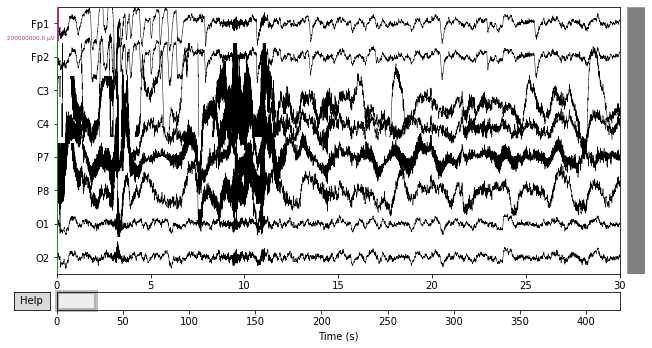

In [19]:
_ = mne.viz.plot_raw(
    baseline_raw,
    duration=30, 
    start=0, 
    scalings=100,
    show=True
)

### Добавить STI канал для фиксации событий

In [23]:
sfreq = int(baseline_raw.info["sfreq"])

In [24]:
eeg_data = baseline_raw.get_data()

In [25]:
# eval(events_df["json"].iloc[0])

In [26]:
# Событие - наличие или отсутствие пустой катушки в состоянии 000
def check_hypothesis(response):
    response = response["response"]
    return "".join([str(s) for s in response['result']['state']['towerStages']]) == "000", \
        response["result"]['reels']['view'][0][0] == 5

In [27]:
events_df["type_proxy"] = events_df["json"].apply(lambda x: eval(x)).apply(check_hypothesis)

In [28]:
events_df["type"] = 'unknown'

In [29]:
events_df.loc[events_df["type_proxy"] == (True, True), "type"] = 'empty reel'
events_df.loc[events_df["type_proxy"] == (True, False), "type"] = 'another action'

In [30]:
events_df["type"].value_counts()

unknown           234
another action     41
empty reel         40
Name: type, dtype: int64

In [31]:
stim_channel = np.zeros(eeg_data.shape[1])

true_timestamps = (events_df[events_df["type"] == 'empty reel']["timestamp"] * sfreq).astype(int)
stim_channel[true_timestamps[true_timestamps < stim_channel.shape[0]]] = 1

false_timestamps = (events_df[events_df["type"] == 'another action']["timestamp"] * sfreq).astype(int)
stim_channel[false_timestamps[false_timestamps < stim_channel.shape[0]]] = 2

In [33]:
stim_info = mne.create_info(['STI'], baseline_raw.info['sfreq'], ['stim'])

In [34]:
stim_raw = mne.io.RawArray(stim_channel.reshape(1, -1), stim_info)

Creating RawArray with float64 data, n_channels=1, n_times=108904
    Range : 0 ... 108903 =      0.000 ...   425.402 secs
Ready.


In [36]:
baseline_raw.add_channels([stim_raw], force_update_info=True)

<Raw | test-filtered-unprocessed.raw.fif, 9 x 108904 (425.4 s), ~7.5 MB, data loaded>

In [37]:
events = mne.find_events(baseline_raw, stim_channel="STI")

81 events found
Event IDs: [1 2]


In [38]:
raw_part = baseline_raw.copy().pick(["Fp1", "Fp2", "O1", "O2"])

In [80]:
epochs = mne.Epochs(
    baseline_raw,
    events,
    tmin=0.4,
    tmax=0.6,
    preload=True,
    baseline=None
)

Not setting metadata
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Loading data for 81 events and 53 original time points ...
0 bad epochs dropped


In [81]:
epochs_part = epochs.copy().pick(["Fp1", "Fp2", "O1", "O2"])

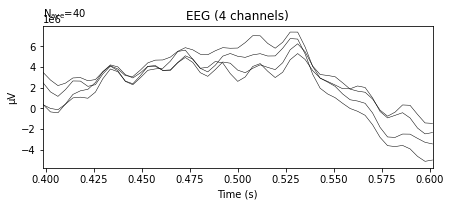

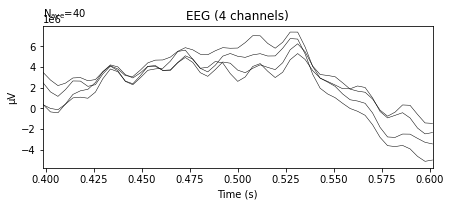

In [82]:
# Средняя попытка для пустой катушки
epochs_part['1'].average().plot()

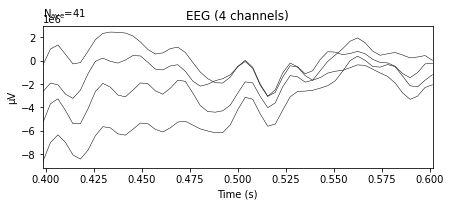

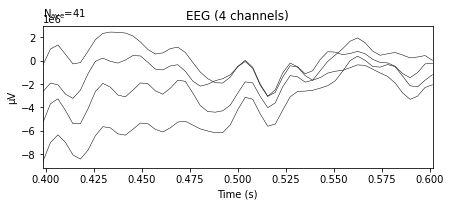

In [83]:
# Средняя попытка для других символов
epochs_part['2'].average().plot()

# Проверка гипотезы

TODO уточнить ожидаемый размер эффекта

Ожидаемый результат - для пустой катушки амплитуда альфа-ритма должна быть больше, чем для других символов

In [84]:
empty_reel_data = epochs_part['1'].get_data()

In [85]:
other_action_data = epochs_part['2'].get_data()

In [86]:
empty_reel_data.shape

(40, 4, 53)

In [87]:
import seaborn as sns

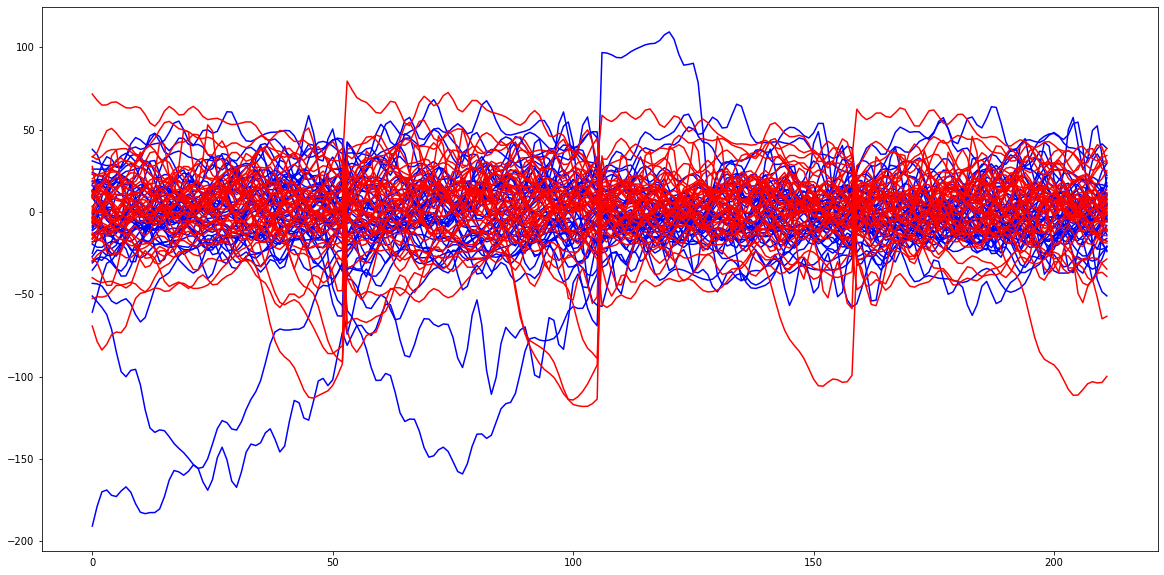

In [88]:
plt.figure(figsize=(20, 10))
plt.plot(other_action_data.reshape(other_action_data.shape[0], -1).T, color='blue')
plt.plot(empty_reel_data.reshape(empty_reel_data.shape[0], -1).T, color='red')
plt.show()

In [89]:
sample_empty = np.abs(empty_reel_data).mean(axis=2).reshape(-1)

In [90]:
sample_other = np.abs(other_action_data).mean(axis=2).reshape(-1)

(array([0.        , 0.00726115, 0.03388535, 0.07019108, 0.07503185,
        0.04598726, 0.03146497, 0.0266242 , 0.01936306, 0.01210191,
        0.01210191, 0.00484076, 0.00968153, 0.01210191, 0.00484076,
        0.00242038, 0.00726115, 0.00242038, 0.00242038]),
 array([ 0.        ,  2.63157895,  5.26315789,  7.89473684, 10.52631579,
        13.15789474, 15.78947368, 18.42105263, 21.05263158, 23.68421053,
        26.31578947, 28.94736842, 31.57894737, 34.21052632, 36.84210526,
        39.47368421, 42.10526316, 44.73684211, 47.36842105, 50.        ]),
 <a list of 19 Patch objects>)

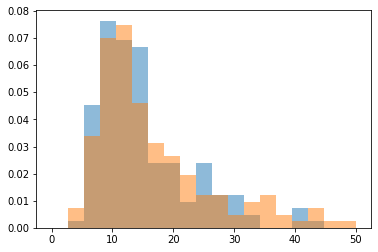

In [91]:
plt.hist(sample_other, bins=np.linspace(0, 50, 20), alpha=0.5, density=True)
plt.hist(sample_empty, bins=np.linspace(0, 50, 20), alpha=0.5, density=True)

In [92]:
from scipy.stats import mannwhitneyu

In [93]:
mannwhitneyu(sample_other, sample_empty)

MannwhitneyuResult(statistic=12352.0, pvalue=0.18129852588958123)